In [1]:
%autosave 5

Autosaving every 5 seconds


In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt

import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch

# Data Preprocessing

In [ ]:
'''Take files from Data_pickle'''
import pickle
import os 
os.chdir('/content/drive/My Drive/AdvancedNLPProject/Sravani/Data_pickle')
with open('Sports_Sentences.pickle', 'rb') as f:
    Sports_Sentences = pickle.load(f)
with open('Health_Sentences.pickle', 'rb') as f:
    Health_Sentences = pickle.load(f)  
with open('Politics_Sentences.pickle', 'rb') as f:
    Politics_Sentences = pickle.load(f) 
with open('Food_Sentences.pickle', 'rb') as f:
    Food_Sentences = pickle.load(f)

In [ ]:
''' While creating MultiTopic Documents { 0: Health , 1 : Sports , 2 : Politics , 3 : Food } '''
Sentences = []
Topic_number =[]
for sentence in Health_Sentences:
  Sentences.append(sentence)
  Topic_number.append(0)

for sentence in Sports_Sentences:
  Sentences.append(sentence)
  Topic_number.append(1)

for sentence in Politics_Sentences:
  Sentences.append(sentence)
  Topic_number.append(2)

for sentence in Food_Sentences:
  Sentences.append(sentence)
  Topic_number.append(3)

print(len(Sentences),len(Topic_number))

130088 130088


# Start

In [ ]:
Data_Train = pd.read_csv("/content/drive/My Drive/AdvancedNLPProject/Sravani/train.csv")
Data_val = pd.read_csv("/content/drive/My Drive/AdvancedNLPProject/Sravani/validation.csv")
Data_Train.rename(columns = {'text':'Sentence'}, inplace = True)
Data_val.rename(columns = {'text':'Sentence'}, inplace = True)
Data_Train.rename(columns = {'labels':'label'}, inplace = True)
Data_val.rename(columns = {'labels':'label'}, inplace = True)
Data_Train.head()

,Unnamed: 0,Sentence,label
0,47436,18 and made their second appearance of the sea...,1
1,65348,This piece was updated to clarify that that ma...,2
2,82315,Here's where he stands on the issues..Louisian...,2
3,117773,"thus, epb <dig> l5/more function is required t...",0
4,625,These include all 21 essential amino acids and...,3


In [ ]:
import re

def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '', x)
        x = re.sub('[0-9]{4}', '', x)
        x = re.sub('[0-9]{3}', '', x)
        x = re.sub('[0-9]{2}', '', x)
    return x

In [ ]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

In [ ]:
# lower the text
Data_Train["Sentence"] = Data_Train["Sentence"].apply(lambda x: x.lower())

# Clean the text
Data_Train["Sentence"] = Data_Train["Sentence"].apply(lambda x: clean_text(x))

# Clean numbers
Data_Train["Sentence"] = Data_Train["Sentence"].apply(lambda x: clean_numbers(x))

# Clean Contractions
Data_Train["Sentence"] = Data_Train["Sentence"].apply(lambda x: replace_contractions(x))



# lower the text
Data_val["Sentence"] = Data_val["Sentence"].apply(lambda x: x.lower())

# Clean the text
Data_val["Sentence"] = Data_val["Sentence"].apply(lambda x: clean_text(x))

# Clean numbers
Data_val["Sentence"] = Data_val["Sentence"].apply(lambda x: clean_numbers(x))

# Clean Contractions
Data_val["Sentence"] = Data_val["Sentence"].apply(lambda x: replace_contractions(x))

In [ ]:
from sklearn.model_selection import train_test_split
train_X, train_y = Data_Train['Sentence'], Data_Train['label']
test_X, test_y = Data_val['Sentence'], Data_val['label']
                                                   

In [ ]:
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (97566,)
Test shape :  (32522,)


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_features = 120000 # how many unique words to use (i.e num rows in embedding vector) . This is also the vocabulary size 
maxlen = 750 # max number of words in a question to use

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)


In [ ]:
'''Unzipping Files '''
# import os 
# os.chdir('/content/drive/My Drive/AdvancedNLPProject/Sravani/Data')
# !unzip -u "/content/drive/My Drive/AdvancedNLPProject/Sravani/Data/glove.840B.300d.zip" -d "/content/drive/My Drive/AdvancedNLPProject/Sravani/Data"

Archive:  /content/drive/My Drive/AdvancedNLPProject/Sravani/Data/glove.840B.300d.zip


In [ ]:
import numpy as np 
def load_glove(word_index):
    EMBEDDING_FILE = '/content/drive/My Drive/AdvancedNLPProject/Sravani/Data/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding = 1
if embedding :
  embedding_matrix = load_glove(tokenizer.word_index)
else :
  embedding_matrix = np.random.randn(120000,300)
np.shape(embedding_matrix)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


(61556, 300)

# Convolution Network based PyTorch Implementation

In [ ]:
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [1,2,3,5]
        num_filters = 36
        n_classes = 4
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit

In [ ]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import f1_score
# from torch.optim.optimizer import Optimizer

# from sklearn.preprocessing import StandardScaler
# from multiprocessing import  Pool
# from functools import partial
# import numpy as np
# from sklearn.decomposition import PCA
# import torch as t
# import torch.nn as nn
# import torch.nn.functional as F
# from sklearn.metrics import f1_score

# import matplotlib.pyplot as plt

# import random
# import copy
# import time
# import pandas as pd
# import numpy as np
# import gc
# import re
# import torch


n_epochs = 10
number_of_classes = 4
embed_size = 300 # how big is each word vector
batch_size = 512 # how many samples to process at once
n_splits = 5 # Number of K-fold Splits
SEED = 10

model = CNN_Text()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y.to_numpy()).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y.to_numpy()).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),number_of_classes))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    pre_y = val_preds.argmax(axis=1)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f} \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/10 	 loss=161.1703 	 val_loss=96.4395  	 val_acc=0.9251 	 time=49.04s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 2/10 	 loss=89.6356 	 val_loss=85.3690  	 val_acc=0.9336 	 time=50.99s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 3/10 	 loss=77.6093 	 val_loss=81.0239  	 val_acc=0.9360 	 time=53.72s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 4/10 	 loss=68.7644 	 val_loss=79.9962  	 val_acc=0.9358 	 time=55.26s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 5/10 	 loss=61.7311 	 val_loss=77.5515  	 val_acc=0.9383 	 time=56.98s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 6/10 	 loss=56.2750 	 val_loss=77.1188  	 val_acc=0.9384 	 time=57.43s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 7/10 	 loss=50.4378 	 val_loss=78.0216  	 val_acc=0.9389 	 time=58.70s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 8/10 	 loss=46.3940 	 val_loss=78.8401  	 val_acc=0.9392 	 time=58.85s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 9/10 	 loss=42.6108 	 val_loss=79.1348  	 val_acc=0.9400 	 time=59.46s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 10/10 	 loss=38.7836 	 val_loss=80.5232  	 val_acc=0.9391 	 time=59.21s


In [ ]:
torch.save(model,'/content/drive/My Drive/AdvancedNLPProject/Sravani/Models/textcnn_model2')

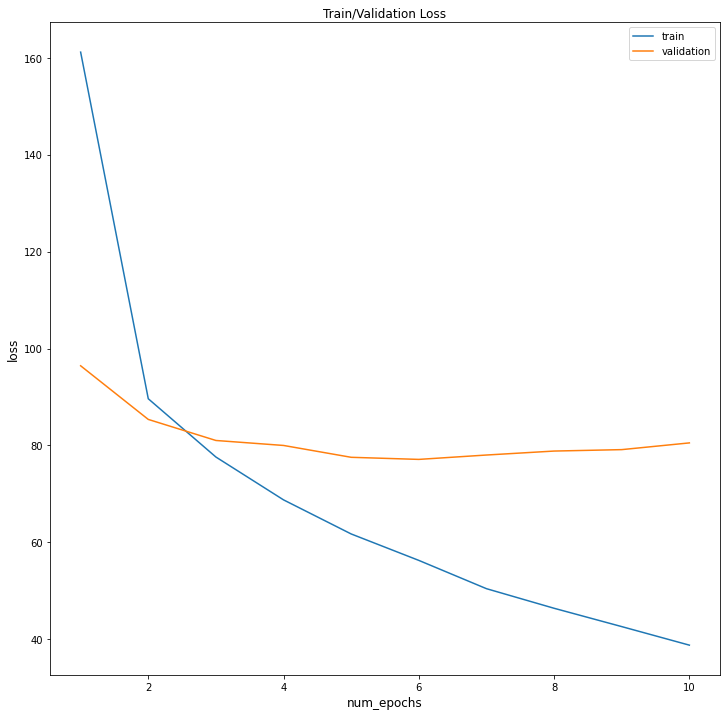

In [ ]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
plot_graph(n_epochs)

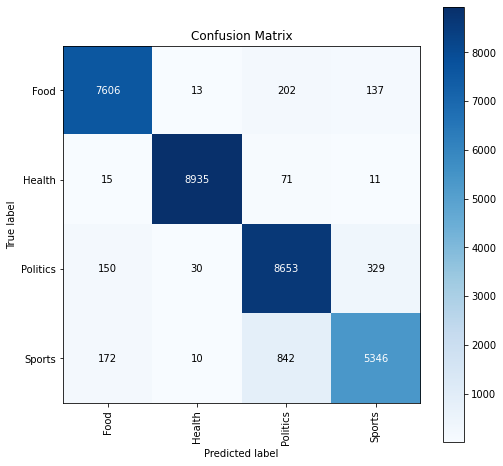

In [ ]:
!pip install scikit-plot
import scikitplot as skplt
from scikitplot.estimators import plot_feature_importances
from scikitplot.metrics import plot_confusion_matrix, plot_roc
classes = ['Health','Sports','Politics','Food']
y_true = [classes[x] for x in test_y]
y_pred = [classes[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(8,8),x_tick_rotation=90)

# LSTM based Pytorch Implementation

In [ ]:
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.1
        n_classes = 4
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True , num_layers=64)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [ ]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import f1_score
# from torch.optim.optimizer import Optimizer

# from sklearn.preprocessing import StandardScaler
# from multiprocessing import  Pool
# from functools import partial
# import numpy as np
# from sklearn.decomposition import PCA
# import torch.nn as nn
# import torch.nn.functional as F
# from sklearn.metrics import f1_score

# import matplotlib.pyplot as plt

# import random
# import copy
# import time
# import pandas as pd
# import numpy as np
# import gc
# import re
# import torch

torch.cuda.empty_cache()

n_epochs = 10
number_of_classes = 4
embed_size = 300 # how big is each word vector
batch_size = 512 # how many samples to process at once
n_splits = 5 # Number of K-fold Splits
SEED = 10

model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y.to_numpy()).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y.to_numpy()).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),number_of_classes))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss) 
    elapsed_time = time.time() - start_time
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f} \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy,elapsed_time))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/10 	 loss=328.1544 	 val_loss=131.1009  	 val_acc=0.9094 	 time=130.44s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 2/10 	 loss=132.3609 	 val_loss=107.6067  	 val_acc=0.9170 	 time=129.26s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 3/10 	 loss=99.3889 	 val_loss=94.4059  	 val_acc=0.9263 	 time=129.15s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 4/10 	 loss=89.6662 	 val_loss=89.4310  	 val_acc=0.9303 	 time=129.16s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 5/10 	 loss=84.0193 	 val_loss=89.1423  	 val_acc=0.9323 	 time=129.07s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 6/10 	 loss=78.0201 	 val_loss=87.0375  	 val_acc=0.9313 	 time=128.98s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 7/10 	 loss=72.8127 	 val_loss=84.5776  	 val_acc=0.9347 	 time=128.91s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 8/10 	 loss=69.4233 	 val_loss=85.5804  	 val_acc=0.9338 	 time=129.37s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 9/10 	 loss=66.0124 	 val_loss=81.1444  	 val_acc=0.9364 	 time=129.10s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 10/10 	 loss=60.6900 	 val_loss=84.4313  	 val_acc=0.9363 	 time=129.27s


In [ ]:
torch.save(model,'/content/drive/My Drive/AdvancedNLPProject/Sravani/Models/bilstm_model2')

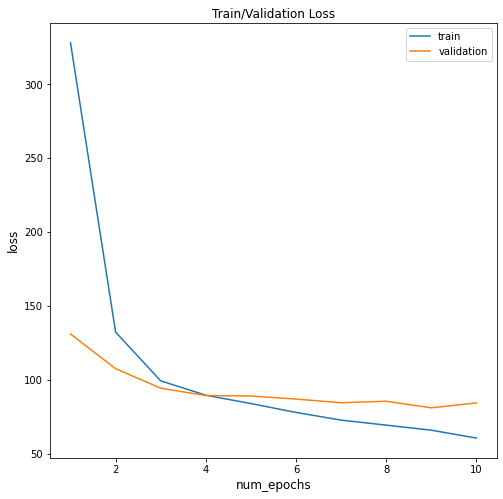

In [ ]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(8,8))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
plot_graph(n_epochs)

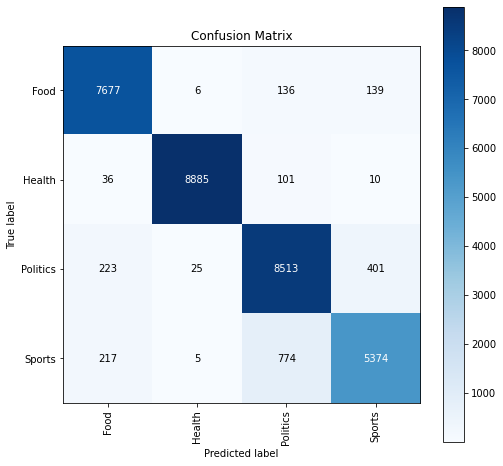

In [ ]:
import scikitplot as skplt
from scikitplot.estimators import plot_feature_importances
from scikitplot.metrics import plot_confusion_matrix, plot_roc
classes = ['Health','Sports','Politics','Food']
y_true = [classes[x] for x in test_y]
y_pred = [classes[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(8,8),x_tick_rotation=90)

# Evaluation

In [ ]:
''' While creating MultiTopic Documents { 0: Health , 1 : Sports , 2 : Politics , 3 : Food } '''
import pandas as pd 
MultiTopicDocs = pd.read_csv("/content/drive/My Drive/AdvancedNLPProject/Sravani/data-4topics500.csv")
MultiTopicDocs.head()

,Unnamed: 0,Doc,Num_of_topics,Topics,Topic_order
0,0,Black students were hurt most when Wellesley t...,3,"['PoliticsPolicy', 'Health', 'Food']","[2, 2, 0, 2, 3, 0, 3, 2, 2, 2, 0, 2, 0, 0, 0, ..."
1,1,BACKGROUND.\nant colony algorithm belongs to ...,3,"['Food', 'Health', 'Sports']","[0, 0, 3, 1, 3, 3, 3, 3, 1, 1, 0, 1, 3, 3, 3, ..."
2,2,BACKGROUND.\n9 myths about sexual assault.\nlo...,4,"['PoliticsPolicy', 'Health', 'Food', 'Sports']","[0, 2, 0, 0, 2, 2, 1, 0, 2, 0, 2, 3, 0, 3, 3, ..."
3,3,Jockey Ramon Dominguez has made enough progres...,2,"['Sports', 'Food']","[1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, ..."
4,4,Love it!I really like the flavor of this one!\...,2,"['Food', 'PoliticsPolicy']","[3, 2, 2, 3, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 2, ..."


In [ ]:
def predict_single(x):    
    # lower the text
    x = x.lower()
    # Clean the text
    x =  clean_text(x)
    # Clean numbers
    x =  clean_numbers(x)
    # Clean Contractions
    x = replace_contractions(x)
    # tokenize
    x = tokenizer.texts_to_sequences([x])
    # pad
    x = pad_sequences(x, maxlen=maxlen)
    # create dataset
    x = torch.tensor(x, dtype=torch.long).cuda()

    pred = model(x).detach()
    pred = F.softmax(pred).cpu().numpy()

    pred = pred.argmax(axis=1)
    return pred[0]

# CNN Evaluation

In [ ]:
'''CNN Evaluation'''
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
import re
import torch



model = torch.load('/content/drive/My Drive/AdvancedNLPProject/Sravani/Models/textcnn_model2')
ind_accuracy=[]
ind_fscore_macro=[]
ind_fscore_micro=[]
ind_fscore_weighted=[]
mcc_score = []

for index, row in MultiTopicDocs.iterrows():
    Document= row['Doc'].split("\n")
    Topics_order_string = row['Topic_order']
    Topics_order_string = Topics_order_string.replace("[", "")
    Topics_order_string = Topics_order_string.replace("]", "")
    actual_topic_order = Topics_order_string.split(",")
    # print(len(Document),len(actual_topic_order))
    predicted_topic_order = []
    for sentence in Document : 
      predicted_topic_order.append(predict_single(sentence))
      
    # print(predicted_topic_order,actual_topic_order)
    '''Document-Accuracy'''
    actual_topic_order_num = [int(i) for i in actual_topic_order] 
    match = 0
    for i in range(0,len(actual_topic_order_num)):
      if actual_topic_order_num[i]==predicted_topic_order[i]:
        match = match+1
    ind_accuracy.append(match/len(actual_topic_order_num))

    '''Document F1score'''
    f1score = f1_score(actual_topic_order_num, predicted_topic_order, average='micro')
    ind_fscore_micro.append(f1score)

    f1score = f1_score(actual_topic_order_num, predicted_topic_order, average='macro')
    ind_fscore_macro.append(f1score)

    f1score = f1_score(actual_topic_order_num, predicted_topic_order, average='weighted')
    ind_fscore_weighted.append(f1score)

    '''mcc score '''
    mcc = matthews_corrcoef(actual_topic_order_num, predicted_topic_order)
    mcc_score.append(mcc)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
print("No of Documents :" ,len(ind_accuracy))
print("Accuracy : ",sum(ind_accuracy)/len(ind_accuracy))
print("F1Score(Micro) : " ,sum(ind_fscore_micro)/len(ind_fscore_micro))
print("F1Score(Macro) : " ,sum(ind_fscore_macro)/len(ind_fscore_macro))
print("F1Score(Weighted) : " ,sum(ind_fscore_weighted)/len(ind_fscore_weighted))
print("MCC : " ,sum(mcc_score)/len(mcc_score))

No of Documents : 500
Accuracy :  0.8976583200397976
F1Score(Micro) :  0.8976583200397975
F1Score(Macro) :  0.714433093024191
F1Score(Weighted) :  0.9176512061366098
MCC :  0.7935713854417699


# LSTM Evaluation

In [ ]:
'''BiLSTM Evaluation'''
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
import re
model = torch.load('/content/drive/My Drive/AdvancedNLPProject/Sravani/Models/bilstm_model2')
ind_accuracy=[]
ind_fscore_macro=[]
ind_fscore_micro=[]
ind_fscore_weighted=[]
mcc_score = []
for index, row in MultiTopicDocs.iterrows():
    Document= row['Doc'].split("\n")
    Topics_order_string = row['Topic_order']
    Topics_order_string = Topics_order_string.replace("[", "")
    Topics_order_string = Topics_order_string.replace("]", "")
    actual_topic_order = Topics_order_string.split(",")
    # print(len(Document),len(actual_topic_order))
    predicted_topic_order = []
    for sentence in Document : 
      predicted_topic_order.append(predict_single(sentence))
      
    '''Document-Accuracy'''
    actual_topic_order_num = [int(i) for i in actual_topic_order] 
    match = 0
    for i in range(0,len(actual_topic_order_num)):
      if actual_topic_order_num[i]==predicted_topic_order[i]:
        match = match+1
    ind_accuracy.append(match/len(actual_topic_order_num))

    '''Document F1score'''
    f1score = f1_score(actual_topic_order_num, predicted_topic_order, average='micro')
    ind_fscore_micro.append(f1score)

    f1score = f1_score(actual_topic_order_num, predicted_topic_order, average='macro')
    ind_fscore_macro.append(f1score)

    f1score = f1_score(actual_topic_order_num, predicted_topic_order, average='weighted')
    ind_fscore_weighted.append(f1score)

    '''mcc score '''
    mcc = matthews_corrcoef(actual_topic_order_num, predicted_topic_order)
    mcc_score.append(mcc)
    


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [4]:
print("No of Documents :" ,len(ind_accuracy))
print("Accuracy : ",sum(ind_accuracy)/len(ind_accuracy))
print("F1Score(Micro) : " ,sum(ind_fscore_micro)/len(ind_fscore_micro))
print("F1Score(Macro) : " ,sum(ind_fscore_macro)/len(ind_fscore_macro))
print("F1Score(Weighted) : " ,sum(ind_fscore_weighted)/len(ind_fscore_weighted))
print("MCC : " ,sum(mcc_score)/len(mcc_score))


No of Documents :500
Accuracy : 0.9028941849169204
F1Score(Micro) : 0.9028941849169204
F1Score(Macro) : 0.755687087913663
F1Score(Weighted) : 0.9334771423177188
MCC : 0.8002241284941775
